# Brookshire analysis

Endogenous Rhythmic Attention project, 2019-2023

<b>Author</b>: Olof J. van der Werf
<br><b>Last updated</b>: 21-03-2023

[reference + DOI to publication]

### Purpose of this notebook

This notebook performs the extra analysis (Brookshire et al., 2022) suggested by reviewer # 3.

Specifically ran in it's own environment (oscina, see GitHub page of Geoffrey Brookshire)

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
import oscina

### Set variables

In [3]:
# folder where the clean data is
clean_data_folder = 'data/data_after_cleaning/'
results_folder = 'data/results/'

# time bins
start_time = 0.490
end_time = 1.690
resolution = 0.001
num_time_bins = int((end_time - start_time) / resolution) + 2
intervals = np.round(np.linspace(start_time, end_time, num = num_time_bins),3)

# frequency bins
low_freq = 2
high_freq = 20
resolution = 0.1
num_freq_bins = int((high_freq - low_freq) / resolution) + 1
frequencies =  np.linspace(low_freq, high_freq, num = num_freq_bins)

# sigma of the Gaussian for the convolution
sigma = 0.01

# permutations
nr_of_permutations = 1000
permutations = np.linspace(1,nr_of_permutations,nr_of_permutations).astype(int)

# relevant condition lists
conditions = ['60','80','100']
validities = ['valid','invalid']
visual_fields = ['left','right','both']
subjects = ['03','04','05','06','09','11','12','14','15','17','18','19','20','21','26','27','30','31','32','33','34','35','37','38','39','40']

## Import data

In [4]:
file = clean_data_folder +'trials.csv'
trials = pd.read_csv(file, sep = ',', index_col = 0,dtype = 'str', converters = {'cue-target interval': float, 'reaction time': float})
trials.head(10)

,subject,condition,validity,cue side,cue-target interval,reaction time,response
0,03,60,valid,right,1.500,674.346,correct
1,03,60,valid,right,1.033,535.099,correct
2,03,60,invalid,right,1.667,677.154,correct
3,03,60,invalid,right,0.700,642.355,correct
4,03,60,valid,left,1.200,649.998,correct
5,03,60,valid,right,0.983,453.680,correct
6,03,60,valid,right,1.517,466.662,correct
7,03,60,valid,left,0.917,478.815,correct
8,03,60,invalid,left,0.567,659.850,correct
9,03,60,valid,right,0.633,675.943,correct


In [5]:
trials['cue-target interval'].sort_values().unique()

array([0.5  , 0.517, 0.533, 0.55 , 0.567, 0.583, 0.6  , 0.617, 0.633,
       0.65 , 0.667, 0.683, 0.7  , 0.717, 0.733, 0.75 , 0.767, 0.783,
       0.8  , 0.817, 0.833, 0.85 , 0.867, 0.883, 0.9  , 0.917, 0.933,
       0.95 , 0.967, 0.983, 1.   , 1.017, 1.033, 1.05 , 1.067, 1.083,
       1.1  , 1.117, 1.133, 1.15 , 1.167, 1.183, 1.2  , 1.217, 1.233,
       1.25 , 1.267, 1.283, 1.3  , 1.317, 1.333, 1.35 , 1.367, 1.383,
       1.4  , 1.417, 1.433, 1.45 , 1.467, 1.483, 1.5  , 1.517, 1.533,
       1.55 , 1.567, 1.583, 1.6  , 1.617, 1.633, 1.65 , 1.667, 1.683])

## Run main pre-processing and analysis loop

Steps in this loop:
<ul>
<li> Filter data for the specific factor (validity, visual field, cue validity condition) </li>
<li> Convoluting trials to obtain a time series of reaction time accross cue-target intervals </li>
<li> Detrending trials </li>
<li> Run stLSS analysis </li>
<li> Save output </li>
</ul>

In [6]:
for subject in subjects:
    subset = trials[(trials['condition'] == '60') & 
                     (trials['validity'] == 'valid') &
                     (trials['subject'] == subject) &
                     (trials['cue side'] == 'right') &
                     (trials['response'] == 'correct')]
                     
    avg = np.std(subset['reaction time'])             
    print('Subject '+subject+':'+str(avg))

Subject 03:73.10157801832662
Subject 04:87.41640629041427
Subject 05:143.98009636123209
Subject 06:77.62362465664472
Subject 09:73.80079568535211
Subject 11:119.37614273600597
Subject 12:115.66935084057857
Subject 14:76.36555598260493
Subject 15:95.81116679018419
Subject 17:64.1732525085355
Subject 18:76.03453724480856
Subject 19:117.83923638753954
Subject 20:121.43138104342987
Subject 21:89.3905040178757
Subject 26:56.33404540659906
Subject 27:77.42508753360686
Subject 30:91.58242835524612
Subject 31:114.08991709427637
Subject 32:113.2329435234993
Subject 33:76.63674666482059
Subject 34:109.11392615613501
Subject 35:127.97359237460216
Subject 37:95.30159478381141
Subject 38:117.21991452437584
Subject 39:128.37549055276392
Subject 40:106.92853685059954


In [7]:
subset = trials[(trials['condition'] == '60') & 
                     (trials['validity'] == 'valid') &
                     (trials['cue side'] == 'right') &
                     (trials['response'] == 'correct')]
t = subset['cue-target interval'].to_numpy()
x = subset['reaction time'].to_numpy()

subset = (subset.groupby('cue-target interval', as_index=False).agg(np.mean))

t_avg = subset['cue-target interval'].to_numpy()
x_avg = subset['reaction time'].to_numpy()

f_sample = 60

Text(0, 0.5, 'Amplitude')

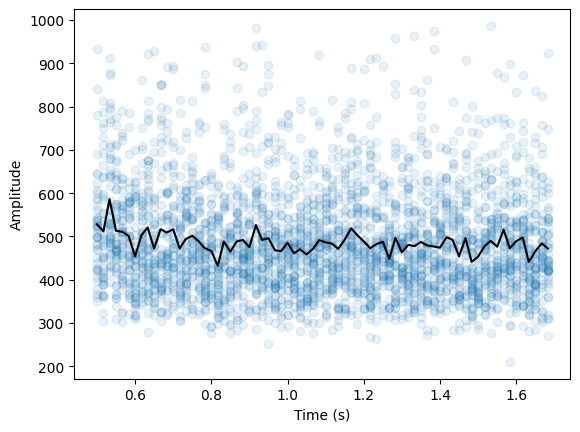

In [8]:
plt.plot(t, x, 'o', alpha=0.1)
plt.plot(t_avg, x_avg, '-k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [9]:
def plot_results(res):
    plt.plot(res['f'], res['y_emp'],
             label='Spectrum')
    if 'y_perm' in res:
        plt.plot(res['f'],
                 np.percentile(res['y_perm'], 95, axis=0),
                 '--k',
                 label='95% CI')
    signif = res['p_corr'] < 0.05
    plt.plot(res['f'][signif], res['y_emp'][signif],
             '*r',
             label='p < .05')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(1, 15)
    plt.legend()  

Text(0.5, 1.0, 'AR Surrogate')

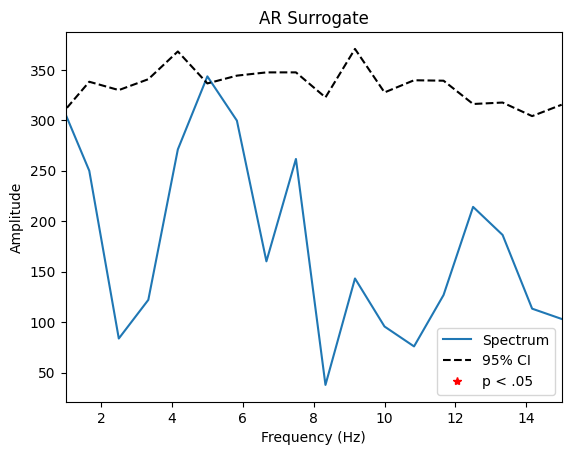

In [10]:
res = oscina.ar_surr(x_avg, f_sample, freq_cutoff=15, k_perm=500,correction = 'fdr')
plot_results(res)
plt.title('AR Surrogate')

In [11]:
# p-value
for i,frequency in enumerate(res['f']):
    print(str(round(frequency,2)) + ' Hz: '+ str(round(res['p_raw'][i],2)))

0.83 Hz: 0.04
1.67 Hz: 0.22
2.5 Hz: 0.86
3.33 Hz: 0.68
4.17 Hz: 0.19
5.0 Hz: 0.04
5.83 Hz: 0.11
6.67 Hz: 0.55
7.5 Hz: 0.18
8.33 Hz: 0.96
9.17 Hz: 0.56
10.0 Hz: 0.79
10.83 Hz: 0.88
11.67 Hz: 0.65
12.5 Hz: 0.27
13.33 Hz: 0.35
14.17 Hz: 0.67
15.0 Hz: 0.71


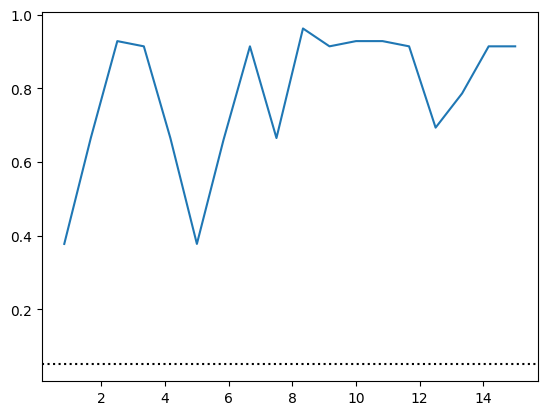

In [12]:
# plot corrected p-values
plt.plot(res['f'],res['p_corr'])
plt.axhline(0.05,linestyle='dotted',color='black')

In [13]:
# corrected p-value
for i,frequency in enumerate(res['f']):
    print(str(round(frequency,2)) + ' Hz: '+ str(round(res['p_corr'][i],2)))

0.83 Hz: 0.38
1.67 Hz: 0.66
2.5 Hz: 0.93
3.33 Hz: 0.91
4.17 Hz: 0.66
5.0 Hz: 0.38
5.83 Hz: 0.66
6.67 Hz: 0.91
7.5 Hz: 0.66
8.33 Hz: 0.96
9.17 Hz: 0.91
10.0 Hz: 0.93
10.83 Hz: 0.93
11.67 Hz: 0.91
12.5 Hz: 0.69
13.33 Hz: 0.79
14.17 Hz: 0.91
15.0 Hz: 0.91


Text(0.5, 1.0, 'Robust estimate')

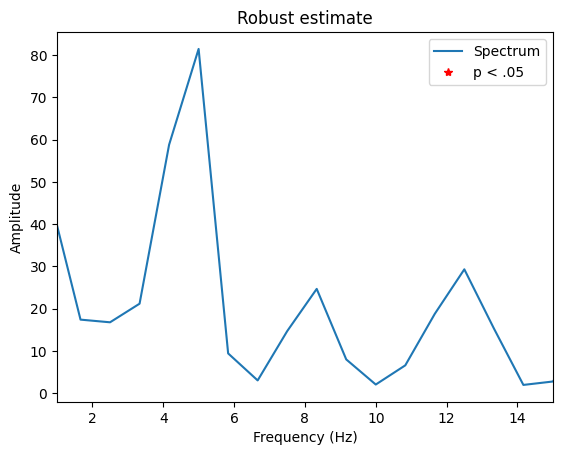

In [14]:
# robust estimate
res = oscina.robust_est(x_avg, f_sample,freq_cutoff=20)
plot_results(res)
plt.title('Robust estimate')

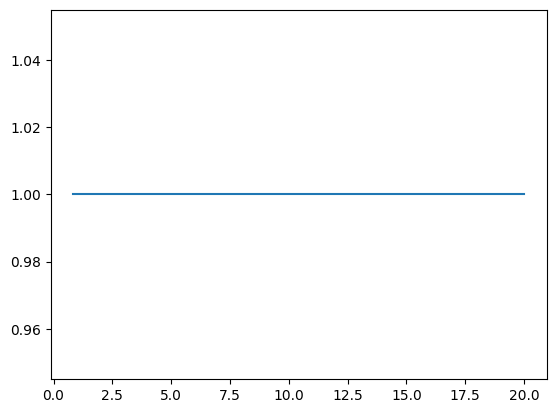

In [15]:
# plot p-values
plt.plot(res['f'],res['p_corr'])

The end.